In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [2]:
# Reading data

path = "/content/drive/MyDrive/cognizant internship/task 3/"

sales_df = pd.read_csv(f"{path}sales.csv")
sales_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
sales_df.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [3]:
stock_df = pd.read_csv(f"{path}sensor_stock_levels.csv")
stock_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
stock_df.head()

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:17:43,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:29:09,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:46:18,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [4]:
temp_df = pd.read_csv(f"{path}sensor_storage_temperature.csv")
temp_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
temp_df.head()

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:12:26,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:30:42,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:09:33,1.38


# Data preparation

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [6]:
# Change data type to datetime

sales_df.timestamp = sales_df.timestamp.apply(lambda x: pd.to_datetime(x[0:13]))

In [7]:
# Output a report for dataframe sales_df

profile = ProfileReport(sales_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Create a function to calculate the interquartile range

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

Feature transaction_id
Categorical feature
----------------------------------------
Feature timestamp
Lower border -  2022-02-24 23:30:00 
Upper border -  2022-03-12 03:30:00 
Number of anomalies -  0
Categorical feature
----------------------------------------
Feature product_id
Categorical feature
----------------------------------------
Feature category
Categorical feature
----------------------------------------
Feature customer_type
Categorical feature
----------------------------------------
Feature unit_price
Lower border -  -6.809999999999999 
Upper border -  21.99 
Number of anomalies -  31


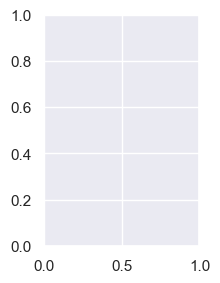

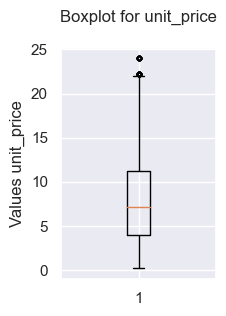

----------------------------------------
Feature quantity
Lower border -  -3.5 
Upper border -  8.5 
Number of anomalies -  0


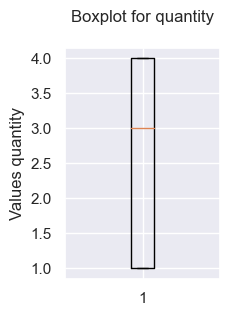

----------------------------------------
Feature total
Lower border -  -26.279999999999994 
Upper border -  61.31999999999999 
Number of anomalies -  300


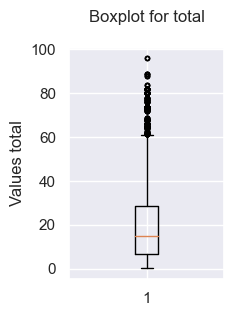

----------------------------------------
Feature payment_type
Categorical feature
----------------------------------------


In [9]:
# Calculation of the interquartile range, outliers and displaying a boxplot for each of the features

for feat in sales_df.columns:
    print('Feature', feat)
    try:
        boundaries = calculate_outliers(sales_df[feat])
        outlier = (sales_df[feat] < boundaries[0]) | (sales_df[feat] > boundaries[1])
        print('Lower border - ', boundaries[0], '\nUpper border - ', boundaries[1], '\nNumber of anomalies - ', outlier.sum())
    
        plt.figure(figsize=(2, 3))
        plt.boxplot(sales_df[feat], sym='.')
        plt.ylabel('Values ' + feat) 
        plt.title('Boxplot for ' + feat + '\n')
        plt.show();
        print(f'{"-" * 40}')
    except:
        print('Categorical feature')
        print(f'{"-" * 40}')

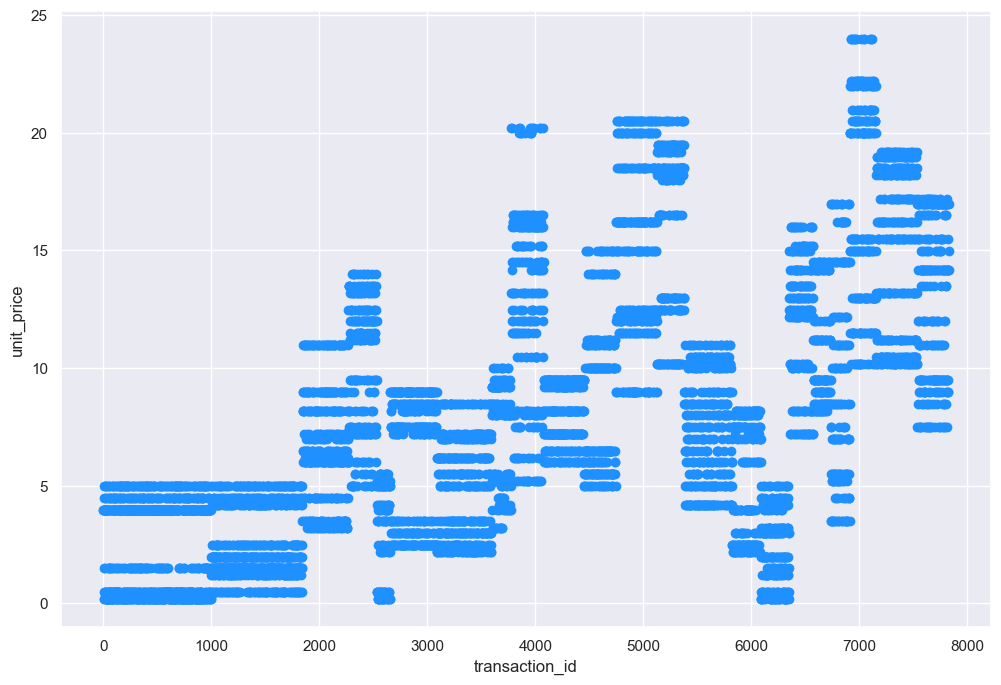

In [11]:
# Check outliers with visual analysis

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(sales_df.index, sales_df['unit_price'], c='dodgerblue')
plt.xlabel('transaction_id')
plt.ylabel('unit_price')
plt.show();

In [12]:
# The data is not outliers, let's leave the dataframe unchanged.

In [13]:
# Change data in stock_df.timestamp type to datetime

stock_df.timestamp = stock_df.timestamp.apply(lambda x: pd.to_datetime(x[0:13]))

In [14]:
# Output a report for dataframe stock_df

profile = ProfileReport(stock_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Change data in temp_df.timestamp type to datetime

temp_df.timestamp = temp_df.timestamp.apply(lambda x: pd.to_datetime(x[0:13]))

In [16]:
# Output a report for dataframe temp_df

profile = ProfileReport(temp_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Lower border -  -9.91 
Upper border -  8.89 
Number of anomalies -  4717


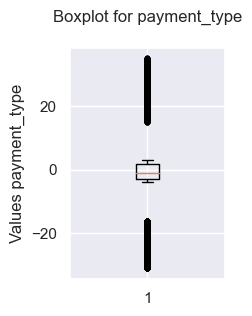

In [17]:
# Calculation of the interquartile range, outliers and displaying a boxplot for temperature

boundaries = calculate_outliers(temp_df['temperature'])
outlier = (temp_df['temperature'] < boundaries[0]) | (temp_df['temperature'] > boundaries[1])
print('Lower border - ', boundaries[0], '\nUpper border - ', boundaries[1], '\nNumber of anomalies - ', outlier.sum())
    
plt.figure(figsize=(2, 3))
plt.boxplot(temp_df['temperature'], sym='.')
plt.ylabel('Values ' + feat) 
plt.title('Boxplot for ' + feat + '\n')
plt.show();

In [18]:
# The change in temperature from 0 to +30 and back and from 0 to -30 and back is too fast. It's probably a sensor error. 
# Remove these outliers

In [19]:
temp_df = temp_df[outlier == False]
temp_df.shape

(19173, 3)

In [20]:
# Calculate the total hourly sales information

sales_stats = sales_df.groupby(['timestamp', 'product_id'], as_index=False)[['quantity']].sum()
sales_stats.head()

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11


In [21]:
# Calculate average hourly data from temperature sensors and stock balances

stock_stats = stock_df.groupby(['timestamp', 'product_id'], as_index=False)[['estimated_stock_pct']].mean()
stock_stats.head()

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05


In [22]:
temp_stats = temp_df.groupby(['timestamp'], as_index=False)[['temperature']].mean()
temp_stats.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.420700
1,2022-03-01 10:00:00,-0.428033
2,2022-03-01 11:00:00,-0.473264
3,2022-03-01 12:00:00,-0.759837
4,2022-03-01 13:00:00,-0.401673


In [23]:
# Merging all received data into a single dataframe

df_full = pd.merge(left=stock_stats, right=sales_stats, on=['timestamp', 'product_id'], how='left')
df_full.head()

,timestamp,product_id,estimated_stock_pct,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN


In [24]:
df_full = pd.merge(left=df_full, right=temp_stats, on=['timestamp'], how='left')
df_full.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.4207
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.4207
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.4207
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.4207
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.4207


In [25]:
# Adding product category and unit price features to the merged dataframe

category = sales_df[['product_id', 'category']].drop_duplicates()
unit_price = sales_df[['product_id', 'unit_price']].drop_duplicates()

df_full = pd.merge(left=df_full, right=category, on=['product_id'], how='left')
df_full = pd.merge(left=df_full, right=unit_price, on=['product_id'], how='left')
df_full.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.4207,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.4207,vegetables,1.49
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.4207,baby products,14.19
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.4207,beverages,20.19
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.4207,pets,8.19


In [26]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             3067 non-null   float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


In [27]:
# Fill in the gaps in the sales information 0, because missing data indicates that there were no sales of this product during the specified period

df_full.quantity = df_full.quantity.fillna(0)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


# Feature engineering

In [28]:
df_full['hour'] = df_full['timestamp'].dt.hour
df_full['day'] = df_full['timestamp'].dt.day
df_full['dayofweek'] = df_full['timestamp'].dt.dayofweek

# Data transformation

In [29]:
# Transforming categorical variables with OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe_data = ohe.fit_transform(df_full.category.to_numpy().reshape(-1, 1))
ohe_name_list = ['category' + elem[2:] for elem in ohe.get_feature_names_out()]
df_full[ohe_name_list] = ohe_data
df_full.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,hour,day,dayofweek,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.4207,kitchen,11.19,9,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.4207,vegetables,1.49,9,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.4207,baby products,14.19,9,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.4207,beverages,20.19,9,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.4207,pets,8.19,9,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Standardization of variables

quant_list = ['quantity', 'temperature', 'unit_price', 'hour', 'day', 'dayofweek']
data_quant = df_full[quant_list]
std_scaler = StandardScaler()
std_scaler.fit(data_quant)
std_scaled = std_scaler.transform(data_quant)
std_quant_list = ['std_scaled_' + elem for elem in quant_list]
df_full[std_quant_list] = std_scaled
df_full.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,hour,day,dayofweek,...,category_seafood,category_snacks,category_spices and herbs,category_vegetables,std_scaled_quantity,std_scaled_temperature,std_scaled_unit_price,std_scaled_hour,std_scaled_day,std_scaled_dayofweek
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.4207,kitchen,11.19,9,1,1,...,0.0,0.0,0.0,0.0,1.16999,0.742701,0.417705,-1.578795,-1.506777,-0.995194
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.4207,vegetables,1.49,9,1,1,...,0.0,0.0,0.0,1.0,1.16999,0.742701,-1.381928,-1.578795,-1.506777,-0.995194
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.4207,baby products,14.19,9,1,1,...,0.0,0.0,0.0,0.0,-0.50824,0.742701,0.974293,-1.578795,-1.506777,-0.995194
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.4207,beverages,20.19,9,1,1,...,0.0,0.0,0.0,0.0,-0.50824,0.742701,2.087468,-1.578795,-1.506777,-0.995194
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.4207,pets,8.19,9,1,1,...,0.0,0.0,0.0,0.0,-0.50824,0.742701,-0.138883,-1.578795,-1.506777,-0.995194


In [31]:
# Removing non-informative columns and initial features before transformations

columns_for_drop = ['quantity', 'temperature', 'unit_price', 'hour', 'day', 'dayofweek', 'category', 'timestamp', 'product_id']
df_prepared = df_full.drop(columns=columns_for_drop)
print(df_prepared.columns.tolist())

['estimated_stock_pct', 'category_baby products', 'category_baked goods', 'category_baking', 'category_beverages', 'category_canned foods', 'category_cheese', 'category_cleaning products', 'category_condiments and sauces', 'category_dairy', 'category_frozen', 'category_fruit', 'category_kitchen', 'category_meat', 'category_medicine', 'category_packaged foods', 'category_personal care', 'category_pets', 'category_refrigerated items', 'category_seafood', 'category_snacks', 'category_spices and herbs', 'category_vegetables', 'std_scaled_quantity', 'std_scaled_temperature', 'std_scaled_unit_price', 'std_scaled_hour', 'std_scaled_day', 'std_scaled_dayofweek']


# Modeling

In [32]:
# Split into training and test sets

x = df_prepared.drop(['estimated_stock_pct'], axis=1)
y = df_prepared['estimated_stock_pct']

In [34]:
# Fitting the optimal hyperparameters for Ridge and RandomForestRegressor using GridSearchCV

ridge_regression = Ridge()
parametrs = { 'alpha': [1e-7, 1e-6, 1E-5, 1E-4, 1E-3, 1E-2, 0.1, 1, 10, 100, 1E3]
            }
grid = GridSearchCV(ridge_regression, parametrs, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(x, y)
ridge_estimator = grid.best_estimator_

In [ ]:
rf_reg = RandomForestRegressor()
parametrs = { 'n_estimators': [100, 250, 500], 
              'max_features': ['sqrt', 'log2', None], 
              'max_depth': [2, 4, 6, 8], 
              'min_samples_split': [4, 6, 8, 10],
              'criterion': ['squared_error', 'poisson'],
              'n_jobs': [-1]
            }
grid = GridSearchCV(rf_reg, parametrs, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(x, y)
rf_reg_estimator = grid.best_estimator_

In [84]:
# Evaluation of each of the models using cross-validation

scoring = {'MAE': make_scorer(mean_absolute_error), 'MSE': make_scorer(mean_squared_error)}

for model in [ridge_estimator, rf_reg_estimator]:
    cv_score = pd.DataFrame(cross_validate(model, x, y, cv=5, n_jobs=-1, scoring=scoring, return_train_score=True))
    print('Mean metrics values on cross validate:')
    print(f'Model {(str(model).split("(")[0])}:\nMAE for train sample - {round(cv_score.train_MAE.mean(), 3)}\
          \nMSE for train sample - {round(cv_score.train_MSE.mean(), 3)}')  
    print(f'MAE for test sample - {round(cv_score.test_MAE.mean(), 3)}\nMSE for test sample - \
         {round(cv_score.test_MSE.mean(), 3)}\n{"-" * 40}')  

Mean metrics values on cross validate:
Model Ridge:
MAE for train sample - 0.222          
MSE for train sample - 0.07
MAE for test sample - 0.223
MSE for test sample -          0.07
----------------------------------------
Mean metrics values on cross validate:
Model RandomForestRegressor:
MAE for train sample - 0.222          
MSE for train sample - 0.07
MAE for test sample - 0.223
MSE for test sample -          0.07
----------------------------------------


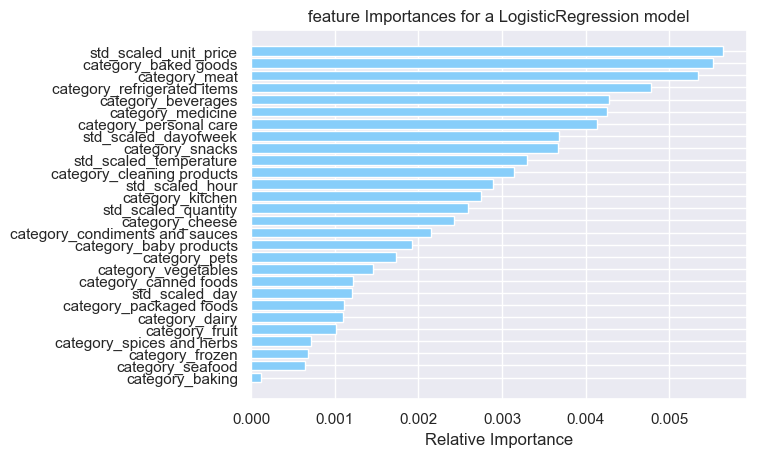

In [85]:
# feature_importances for a Ridge model

features = x.columns

importances = abs(ridge_estimator.coef_)
indices = np.argsort(importances)

plt.title('feature Importances for a Ridge model')
plt.barh(range(len(indices)), importances[indices], color='lightskyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

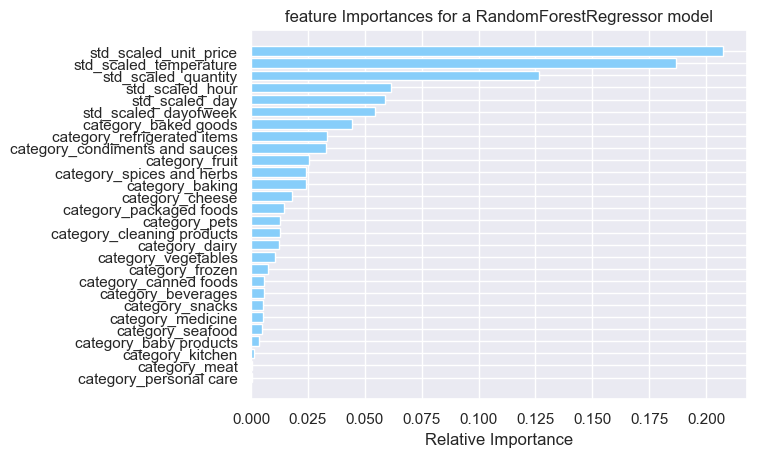

In [86]:
# feature_importances for a RandomForestClassifier model

feat_dict = dict(zip(rf_reg_estimator.feature_names_in_, rf_reg_estimator.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('feature Importances for a RandomForestRegressor model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show();

### The result of the linear model and the random forest model showed equal results, while the MAE and MSE values are quite high and the model needs to be improved. For different models, the importance of features also differs, but for both models, the highest value of importance for the feature is the price of a unit.